## Los Angeles Crime Dashboard: Analyzing and Visualizing Crime Patterns for Public Safety Insights

### Team Members
Aaditya Dharne, Hema Manasi Potnuru, Mahimna Darji, Shubh Mehta

## IMPORTING LIBRARIES

This code block imports all the essential libraries required for data manipulation, visualization, and geospatial analysis: pandas, numpy, matplotlib.pyplot, seaborn, folium and HeatMap For creating interactive maps and visualizing data geographically using heatmaps. And, geopandas for handling and analyzing geospatial data, extending the capabilities of pandas for geographical datasets. Also, plotly.express for creating interactive and dynamic visualizations, such as scatter plots, maps, and bar charts.

These libraries collectively enable a wide range of analytical and visualization capabilities for the project.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
import geopandas as gpd
import plotly.express as px

In [ ]:
!pip install pandas requests

## FETCHING DATA USING API

This code retrieves the data on crime from the Los Angeles open data API in batches of 50,000 records and it combines them into a single DataFrame, saves the dataset as a CSV file (crime_data.csv). The process continues until there's no more data available, with progress logged after each batch. Finally, it displays the first five rows of the data set for verification.

Using the requests library, data is fetched iteratively by updating the offset parameter to ensure all available records are downloaded.
The log messages show the incremental progress of data fetching, with a total of 1,000,000 rows successfully retrieved before reaching the last batch of 41,360 rows.

In [ ]:
import pandas as pd
import requests

# Base API endpoint
api_url = "https://data.lacity.org/resource/2nrs-mtv8.json"
offset = 0
limit = 50000  # Fetch 50,000 rows per request
all_data = []

while True:
    # Fetch data with offset and limit
    response = requests.get(f"{api_url}?$limit={limit}&$offset={offset}")

    # Check for successful response
    if response.status_code != 200:
        print(f"Failed to fetch data at offset {offset}. Status code: {response.status_code}")
        break

    # Convert JSON response to DataFrame
    data = pd.DataFrame(response.json())

    # Break if no more data
    if data.empty:
        print("No more data to fetch.")
        break

    # Append fetched data to list
    all_data.append(data)

    # Update offset
    offset += limit
    print(f"Fetched {len(data)} rows. Total rows fetched: {offset}")

# Concatenate all data into a single DataFrame
crime_data = pd.concat(all_data, ignore_index=True)

# Save to CSV
crime_data.to_csv("crime_data.csv", index=False)

# Verify the data
print(crime_data.head())

Fetched 50000 rows. Total rows fetched: 50000
Fetched 50000 rows. Total rows fetched: 100000
Fetched 50000 rows. Total rows fetched: 150000
Fetched 50000 rows. Total rows fetched: 200000
Fetched 50000 rows. Total rows fetched: 250000
Fetched 50000 rows. Total rows fetched: 300000
Fetched 50000 rows. Total rows fetched: 350000
Fetched 50000 rows. Total rows fetched: 400000
Fetched 50000 rows. Total rows fetched: 450000
Fetched 50000 rows. Total rows fetched: 500000
Fetched 50000 rows. Total rows fetched: 550000
Fetched 50000 rows. Total rows fetched: 600000
Fetched 50000 rows. Total rows fetched: 650000
Fetched 50000 rows. Total rows fetched: 700000
Fetched 50000 rows. Total rows fetched: 750000
Fetched 50000 rows. Total rows fetched: 800000
Fetched 50000 rows. Total rows fetched: 850000
Fetched 50000 rows. Total rows fetched: 900000
Fetched 50000 rows. Total rows fetched: 950000
Fetched 41360 rows. Total rows fetched: 1000000
No more data to fetch.
       dr_no                date_rptd

## DATA CLEANING

The script starts by providing an overview of the dataset, which contains 991,360 records and 28 columns, with several key columns (e.g., victim's age, sex, descent, geolocation, and weapon information) containing missing values. It then performs data cleaning by removing unnecessary columns (`dr_no` and `cross_street`), replacing missing values in critical fields like `vict_sex` and `vict_descent` with default placeholders (`'X'` or `500`), and ensuring `vict_age` is numeric while replacing negatives and NaNs with `0`. Rows with invalid geolocation values (`lat` and `lon`) are also filtered out. After cleaning, the dataset has 26 columns with transformed data, including integer victim ages, improved consistency, and reduced memory usage from 211.8 MB to 196.7 MB. This prepares the dataset for further analysis with cleaner and more structured data.

In [ ]:
# Check basic information about the dataset
print("Basic Dataset Information:")
print(crime_data.info())

# Remove unnecessary columns
columns_to_drop = ['dr_no', 'cross_street']
crime_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Replace missing values in key columns
fill_missing_columns = {
    'vict_sex': 'X',
    'vict_descent': 'X',
    'weapon_used_cd': 500,
    'lat': np.nan,
    'lon': np.nan,
}

crime_data.fillna(value=fill_missing_columns, inplace=True)

crime_data['vict_age'] = pd.to_numeric(crime_data['vict_age'], errors='coerce')

crime_data['vict_age'] = crime_data['vict_age'].apply(lambda x: x if x >= 0 else 0).fillna(0)

crime_data = crime_data[(crime_data['lat'] != 0) & (crime_data['lon'] != 0)]

# Display cleaned data overview
print("Cleaned Data Overview:")
print(crime_data.info())

Basic Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991360 entries, 0 to 991359
Data columns (total 28 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   dr_no           991360 non-null  object
 1   date_rptd       991360 non-null  object
 2   date_occ        991360 non-null  object
 3   time_occ        991360 non-null  object
 4   area            991360 non-null  object
 5   area_name       991360 non-null  object
 6   rpt_dist_no     991360 non-null  object
 7   part_1_2        991360 non-null  object
 8   crm_cd          991360 non-null  object
 9   crm_cd_desc     991360 non-null  object
 10  vict_age        991360 non-null  object
 11  vict_sex        849742 non-null  object
 12  vict_descent    849732 non-null  object
 13  premis_cd       991344 non-null  object
 14  premis_desc     990792 non-null  object
 15  status          991359 non-null  object
 16  status_desc     991360 non-null  object
 17  cr

In [ ]:
# Check for missing values
missing_values = crime_data.isnull().sum()
print("\nMissing Values:")
print(missing_values)


Missing Values:
date_rptd              0
date_occ               0
time_occ               0
area                   0
area_name              0
rpt_dist_no            0
part_1_2               0
crm_cd                 0
crm_cd_desc            0
vict_age               0
vict_sex               0
vict_descent           0
premis_cd             16
premis_desc          568
status                 1
status_desc            0
crm_cd_1              11
crm_cd_2          922336
location               0
lat                    0
lon                    0
mocodes           148484
weapon_used_cd         0
weapon_desc       666318
crm_cd_3          989048
crm_cd_4          991299
dtype: int64


In [ ]:
crime_data = crime_data.dropna(subset=['status', 'premis_cd', 'premis_desc', 'crm_cd_1'])

crime_data = crime_data.drop(columns=['mocodes'])

crime_data['weapon_desc'].fillna("no weapon used", inplace=True)

print("\nUpdated Missing Values:")
print(crime_data.isnull().sum())

<ipython-input-6-4b07a0e02774>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  crime_data['weapon_desc'].fillna("no weapon used", inplace=True)



Updated Missing Values:
date_rptd              0
date_occ               0
time_occ               0
area                   0
area_name              0
rpt_dist_no            0
part_1_2               0
crm_cd                 0
crm_cd_desc            0
vict_age               0
vict_sex               0
vict_descent           0
premis_cd              0
premis_desc            0
status                 0
status_desc            0
crm_cd_1               0
crm_cd_2          921908
location               0
lat                    0
lon                    0
weapon_used_cd         0
weapon_desc            0
crm_cd_3          988469
crm_cd_4          990720
dtype: int64


In [ ]:
x1 =crime_data['vict_age'].unique()
x1= x1.sum()
print(x1)

5069


## STUDYING DATA

We plotted a heatmap to get an overview of dataabout the missing values. If we observe the heatmap, almost every column is completely violet except for crm_cd_2, crm_cd_3, crm_cd_4. This is becasue they are the codes for additional crimes additional to the primary ones if there are any. We also checked for invalid coordinates and duplicate rows.

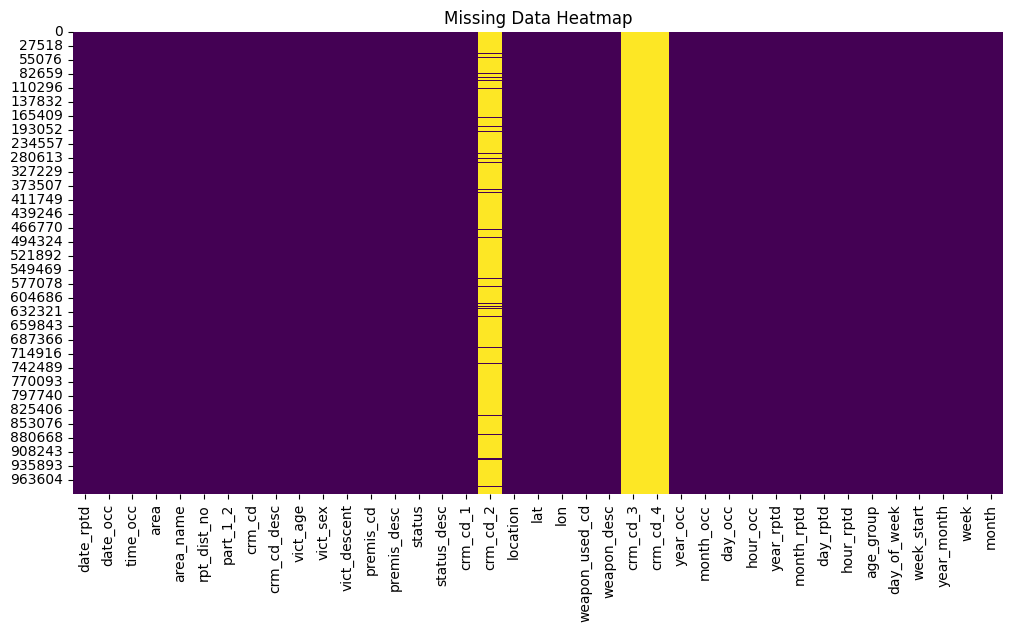

In [ ]:
# Visualize missing data
plt.figure(figsize=(12, 6))
sns.heatmap(crime_data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [ ]:
# Check for duplicate rows
duplicate_rows = crime_data.duplicated().sum()
print("\nNumber of Duplicate Rows:", duplicate_rows)


Number of Duplicate Rows: 84717


In [ ]:
# Drop duplicate rows
crime_data.drop_duplicates(inplace=True)

# Check for invalid coordinates
invalid_coords = crime_data[(crime_data['lat'] == 0) & (crime_data['lon'] == 0)]
print("\nNumber of Invalid Coordinates:", invalid_coords.shape[0])


Number of Invalid Coordinates: 0


## VISUALIZATION 1 : Top 10 Areas with Most Crime

The below plotted bar chart plotted using plotly.express, illustrates the top 10 areas of highest crime counts in the given dataset. Each bar corresponds to an area. In fact, "Central" shows a crime count of 69,275 incidents, ranking highest among these, and "77th Street" has 61,738 incidents. Color  should be used on bars to indicate the variance of crimes by their frequency; dark color shades represent higher counts. The chart has hover functionality for precise values and labels for clarity, making it easy to interpret the crime distribution across these areas. This visualization provides an insightful summary of crime hotspots, aiding in focused analysis or decision-making.

In [ ]:
import plotly.express as px

crime_counts_area = crime_data['area_name'].value_counts().head(10)

data = crime_counts_area.reset_index()
data.columns = ['Area', 'Count']

fig = px.bar(
    data,
    x='Area',
    y='Count',
    title='Top 10 Areas with Most Crime',
    text='Count',
    labels={'Count': 'Crime Count', 'Area': 'Area Name'},
    template='plotly_dark',
    color='Count',
    color_continuous_scale='Blues'
)

fig.update_traces(
    hovertemplate='<b>Area:</b> %{x}<br><b>Crime Count:</b> %{y}<extra></extra>',
    textposition='outside'
)

fig.update_layout(
    title_font=dict(size=12),
    width=1400,
    height=800
)

fig.show()

## VISALIZATION 2: Top 10 Crime Types

The bar chart presents the 10 most frequent types of crime in the dataset, ranked by the number of times each occurred. Bars are color-coded by crime count, where a range of blue shades are used to emphasize differences in crime frequency. The chart is styled with a dark background, providing clean contrast for readability. The y-axis represents the number of crimes, or crime count, while the top 10 crime types are listed on the x-axis. Each bar is labeled with its respective crime count for clarity.

In [ ]:
# Top 10 crime types
top_crime_types = crime_data['crm_cd_desc'].value_counts().head(10)
data = top_crime_types.reset_index()
data.columns = ['Crime Type', 'Number of Crimes']

fig = px.bar(
    data,
    x='Crime Type',
    y='Number of Crimes',
    title='Top 10 Crime Types',
    text='Number of Crimes',
    labels={'Number of Crimes': 'Crime Count', 'Crime Type': 'Crime Type'},
    template='plotly_dark',
    color='Number of Crimes',
    color_continuous_scale='Blues'
)

fig.update_traces(
    hovertemplate='<b>Crime Type:</b> %{x}<br><b>Number of Crimes:</b> %{y}<extra></extra>',
    textposition='outside'
)

fig.update_layout(
    width=1400,
    height=800
)

fig.show()

## Parsing and Cleaning Date Columns in Crime Data

This code block will clean and pre-process the time stamp columns in the crime data set, particularly the date of occurrence, date_rptd. Parsing these columns into datetime format allows for easier manipulation and analysis of the dates. The system then flags invalid dates to be removed. Components of a date, such as year, month, day, hour, are then extracted from the cleaned columns to allow detailed temporal analysis.

After preprocessing, the cleaned dataset is saved to a new CSV file named crime_data_cleaned.csv. A quality check is done to confirm the range of dates in the processed columns, ensuring that the data falls within the expected range.

Below is the example:
DATE OCC Range: 2020-01-01 00:00:00 to 2024-12-09 00:00:00
Date Rptd Range: 2020-01-01 00:00:00 to 2024-12-09 00:00:00
Cleaned Dataset Saved To: crime_data_cleaned.csv

This will ensure that there are no invalid date values in the dataset and it's ready for further analysis with the temporal information in a more usable format.

In [ ]:
# Parse floating timestamp columns into datetime
crime_data['date_occ'] = pd.to_datetime(crime_data['date_occ'], errors='coerce')
crime_data['date_rptd'] = pd.to_datetime(crime_data['date_rptd'], errors='coerce')

# Drop rows with invalid dates
crime_data = crime_data.dropna(subset=['date_occ', 'date_rptd'])

# Extract date components for 'date_occ'
crime_data['year_occ'] = crime_data['date_occ'].dt.year
crime_data['month_occ'] = crime_data['date_occ'].dt.month
crime_data['day_occ'] = crime_data['date_occ'].dt.day
crime_data['hour_occ'] = crime_data['date_occ'].dt.hour

# Extract date components for 'date_rptd'
crime_data['year_rptd'] = crime_data['date_rptd'].dt.year
crime_data['month_rptd'] = crime_data['date_rptd'].dt.month
crime_data['day_rptd'] = crime_data['date_rptd'].dt.day
crime_data['hour_rptd'] = crime_data['date_rptd'].dt.hour

# Save the cleaned dataset to a new file
cleaned_filename = 'crime_data_cleaned.csv'
crime_data.to_csv(cleaned_filename, index=False)

# Confirm the date range for quality check
print("DATE OCC Range:", crime_data['date_occ'].min(), "to", crime_data['date_occ'].max())
print("Date Rptd Range:", crime_data['date_rptd'].min(), "to", crime_data['date_rptd'].max())
print(f"Cleaned dataset saved to: {cleaned_filename}")

DATE OCC Range: 2020-01-01 00:00:00 to 2024-12-09 00:00:00
Date Rptd Range: 2020-01-01 00:00:00 to 2024-12-09 00:00:00
Cleaned dataset saved to: crime_data_cleaned.csv


## VISUALIZATION 3 : Crime Victimization Analysis by Descent

This visualization provides an in-depth look at crime statistics, categorized by the victim's descent and visualized through an interactive dark-themed bar chart. In this bar chart, Plotly Express displays counts of crimes across different categories of descent using a blue color gradient scale with external text labels that show the exact number of crimes. The various insights are supported by an interactive hover tooltip, and the plot dimensions are set to 1400x800 for clarity. The data shows vast victimization disparities, with the highest crimes numbering 291,703 in victims categorized as 'H,' followed by 'X' at 247,658, 'W' at 199,125, and 'B' at 134,060. Other categories had crime counts less than 1,000. This turns raw crime data into a visual, accessible format to be understood quickly and easily by a user for the purpose of analyzing patterns in crime victimization across descent categories.



In [ ]:
# Crime counts by victim's descent
crime_counts_vict_desc = crime_data['vict_descent'].value_counts()
data = crime_counts_vict_desc.reset_index()
data.columns = ['Victim\'s Descent', 'Number of Crimes']

fig = px.bar(
    data,
    x='Victim\'s Descent',
    y='Number of Crimes',
    title='Crime Counts by Victim\'s Descent',
    text='Number of Crimes',
    labels={'Victim\'s Descent': 'Victim\'s Descent', 'Number of Crimes': 'Crime Count'},
    template='plotly_dark',
    color='Number of Crimes',
    color_continuous_scale='Blues'
)

fig.update_traces(
    hovertemplate='<b>Victim\'s Descent:</b> %{x}<br><b>Number of Crimes:</b> %{y}<extra></extra>',
    textposition='outside'
)

fig.update_layout(
    title_font=dict(size=12),
    width=1400,
    height=800
)

fig.show()

## VISUALIZATION 4: Daily Crime Trend Visualization in Los Angeles

This code generates an interactive time series visualization tracking daily crime occurrences in Los Angeles using a dark-themed line plot. It features a date-based x-axis with automated time scaling, a blue-highlighted line, and interactive hover functionality to display precise daily crime counts.

The visualization uncovers several notable trends, such as a significant drop in crimes in early 2021 (from about 800 daily crimes to 300-400), a sharp recovery in 2022 (returning to 600-700 daily incidents), and a gradual decline from 2023 onwards, reaching the lowest levels at 200-300 daily crimes. Short-term fluctuations throughout the timeline suggest weekly or monthly patterns in crime occurrence. This visualization effectively transforms raw crime data into an insightful temporal representation, allowing analysts to identify both long-term trends and short-term patterns in crime rates.

In [ ]:
# Convert 'date_occ' to datetime format and group by date
crime_data['date_occ'] = pd.to_datetime(crime_data['date_occ'], errors='coerce')
daily_crime_counts = crime_data.groupby(crime_data['date_occ'].dt.date).size().reset_index()
daily_crime_counts.columns = ['Date', 'Number of Crimes']

fig = px.line(
    daily_crime_counts,
    x='Date',
    y='Number of Crimes',
    title='Daily Crime Trends in Los Angeles',
    labels={'Date': 'Date', 'Number of Crimes': 'Crime Count'},
    template='plotly_dark',
)

fig.update_traces(
    hovertemplate='<b>Date:</b> %{x}<br><b>Number of Crimes:</b> %{y}<extra></extra>',
    line=dict(color='Blue')
)

fig.update_layout(
    title_font=dict(size=12),
    width=1400,
    height=800

)

fig.show()

## VISUALIZATION 5 : Age Distribution Analysis of Crime Victims

This code generates a pastel-colored pie chart visualizing the distribution of crime victims across different age groups in Los Angeles. The visualization provides clear insights into which age demographics are most affected by crime.

The visualization reveals several key patterns in victim age demographics:
* Young adults (0-18) represent the largest segment at 29.4% of all victims.
* Adults aged 31-45 form the second-largest group at 26.5%.
* Young adults (19-30) constitute 19.5% of victims.
* Middle-aged adults (46-60) account for 15.6%.
* Seniors (61+) represent the smallest proportion at 9.1%.

The implementation effectively highlights the disproportionate impact of crime on younger populations, with nearly 30% of victims being under 19 years old, while showing a generally decreasing trend in victimization as age increases.

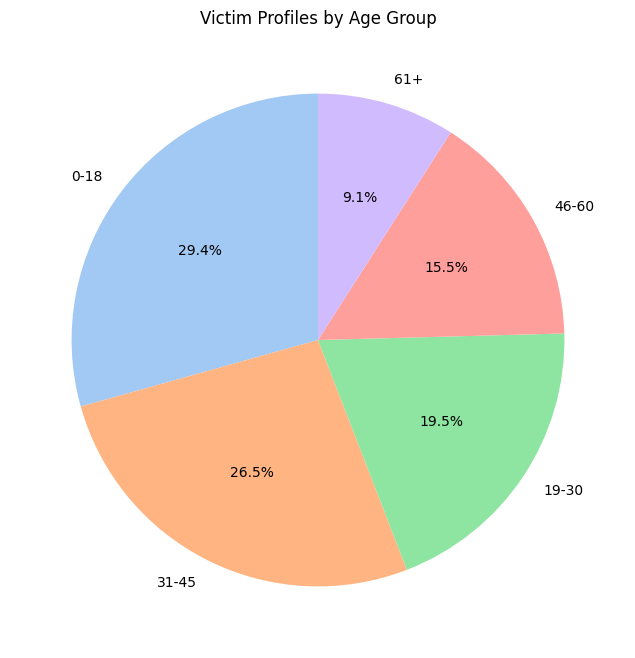

In [ ]:
# Pie Chart of Victim Profiles by Age
age_bins = [0, 18, 30, 45, 60, 100]
age_labels = ['0-18', '19-30', '31-45', '46-60', '61+']
crime_data['age_group'] = pd.cut(crime_data['vict_age'], bins=age_bins, labels=age_labels, right=False)

age_group_counts = crime_data['age_group'].value_counts()
plt.figure(figsize=(16, 8))
age_group_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Victim Profiles by Age Group')
plt.ylabel('')
plt.show()

## VISUALIZATION 6 : Gender Distribution Analysis of Crime Victims

This code generates a pastel-colored pie chart visualizing the distribution of crime victims by gender in Los Angeles. The visualization employs a clear and simple design to highlight gender-based victimization patterns.


The visualization reveals clear patterns in gender-based victimization:
* Males represent the largest proportion at 40.2% of all victims
* Females constitute 35.7% of victims
* Category X accounts for 24.1% of cases
* Category H shows a negligible percentage at 0.0%

The implementation effectively demonstrates that male victims slightly outnumber female victims, while a significant portion of cases (nearly a quarter) fall into the X category, suggesting either unreported or unspecified gender information in the crime data.

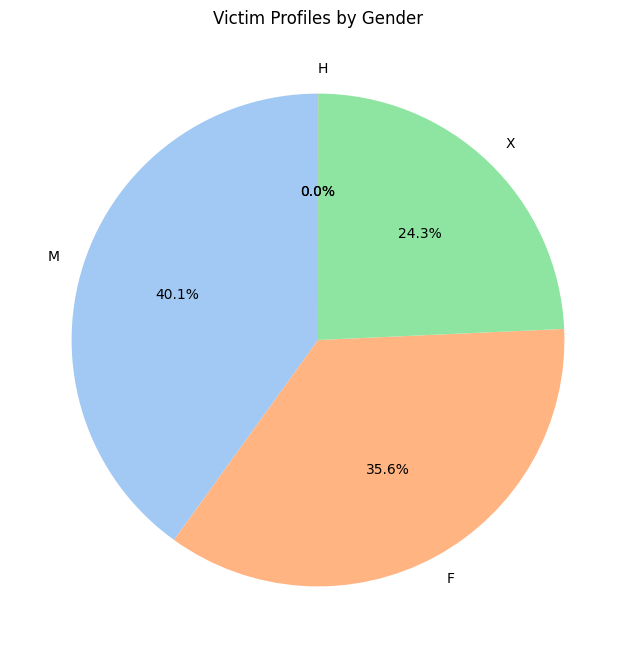

In [ ]:
# Pie Chart of Victim Profiles by Gender
gender_counts = crime_data['vict_sex'].value_counts()
plt.figure(figsize=(16, 8))
gender_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Victim Profiles by Gender')
plt.ylabel('')
plt.show()

## VISUALIZATION 7 : Victim Age Distribution Analysis Across Crime Types

We wrote code to generate a comprehensive visualization combining boxplots and strip plots to analyze the age distribution of crime victims across different crime types in Los Angeles. The dual-plot approach provides both statistical summaries and individual data points for deeper insights.

The visualization reveals several key patterns:
* Most crime types show a wide age distribution from young to elderly victims.
* Certain crimes like theft and burglary show relatively uniform age distributions.
* Some crimes display distinct age clustering, particularly in the 20-40 age range.
* Outliers are effectively visualized through individual points, showing extreme case.
* The median age varies significantly across different crime types, with some crimes predominantly affecting younger populations while others show higher median ages.

The implementation effectively combines statistical summary data with individual data points, providing a nuanced view of how different crime types affect various age groups in the population.

<ipython-input-36-b86a32e35bcf>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




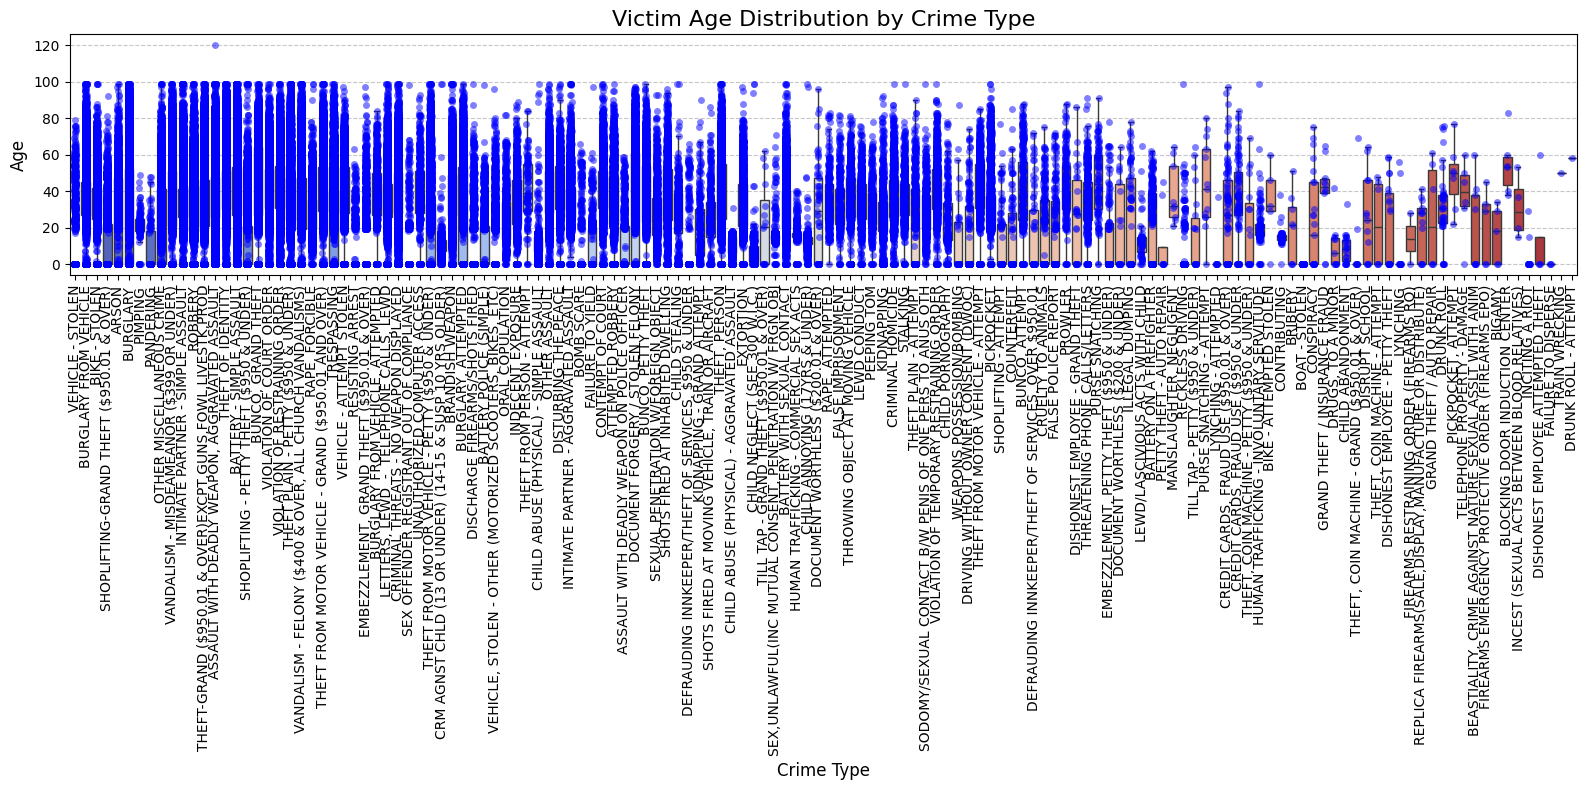

In [ ]:
# Boxplot for Victim Age Distribution by Crime Type
plt.figure(figsize=(16, 8))
sns.boxplot(x='crm_cd_desc', y='vict_age', data=crime_data, palette='coolwarm', showfliers=False)
sns.stripplot(x='crm_cd_desc', y='vict_age', data=crime_data, color='blue', alpha=0.5, jitter=True)

plt.title('Victim Age Distribution by Crime Type', fontsize=16)
plt.xlabel('Crime Type', fontsize=12)
plt.ylabel('Age', fontsize=12)
plt.xticks(rotation=90, fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## VISUALIZATION 8 : Weekly Crime Pattern Analysis

This code generates a line graph visualizing crime trends across different days of the week. The implementation provides insights into the temporal distribution of criminal activities, highlighting patterns and fluctuations throughout a typical week.


The visualization reveals several notable patterns:
* Friday shows the highest crime rate, with over 150,000 incidents.
* A sharp decline in crime occurs from Friday to Monday.
* Saturday experiences the second-highest crime rate.
* Tuesday has the lowest crime rate of the week.
* A gradual increase in crime is observed from Tuesday to Friday.
* Weekends (Friday-Sunday) consistently show higher crime rates than weekdays.

This implementation effectively illustrates the weekly cycle of criminal activity, potentially reflecting societal patterns such as increased social interactions and alcohol consumption on weekends. The insights provided could be valuable for law enforcement resource allocation and crime prevention strategies.

In [ ]:
# Line Graph for Crime Trends by Day of the Week
crime_data['day_of_week'] = crime_data['date_occ'].dt.day_name()
day_of_week_counts = crime_data['day_of_week'].value_counts().reindex(
    ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']
).reset_index()
day_of_week_counts.columns = ['Day of the Week', 'Number of Crimes']

fig = px.line(
    day_of_week_counts,
    x='Day of the Week',
    y='Number of Crimes',
    title='Crime Trends by Day of the Week',
    markers=True,
    template='plotly_dark'
)

fig.update_traces(
    hovertemplate='<b>Day of the Week:</b> %{x}<br><b>Number of Crimes:</b> %{y}<extra></extra>',
    line=dict(color='cyan', width=2)
)

fig.update_layout(
    title_font=dict(size=12),
    width=1400,
    height=800
)


fig.show()

## VISUALIZATION 9 : Long-Term Weekly Crime Trend Analysis

This is to generate a time series visualization tracking weekly crime patterns in Los Angeles from 2020 to 2024. The implementation reveals significant temporal shifts in crime rates and major societal events' impact on criminal activity.

The visualization reveals several distinct periods:
* Early 2020: High crime rates averaging around 5,000-6,000 cases per week.
* Early 2021: Sharp decline to approximately 2,000-2,500 cases weekly.
* 2022: Significant increase back to around 4,000-5,000 weekly cases.
* 2023: Gradual decline trending toward 3,000-4,000 weekly cases.
* 2024: Continued downward trend reaching approximately 2,000 cases per week.
* Final period: Sharp decline to near-zero cases, likely indicating incomplete recent data.

The implementation effectively illustrates both short-term fluctuations and long-term trends in criminal activity, highlighting major shifts in crime patterns over the four-year period. The sharp rise in crime in Los Angeles between 2022 and 2023 could be due to multiple reasons. After the COVID-19 pandemic, economic problems like job losses and inflation increased stress in society, which often leads to more crimes. Changes in law enforcement policies or reduced police presence might have also played a role. Social unrest and protests during this time may have further contributed to the spike.


In [ ]:
# Weekly Crime Trends
crime_data['week_start'] = crime_data['date_occ'] - pd.to_timedelta(crime_data['date_occ'].dt.dayofweek, unit='d')
weekly_trends = crime_data.groupby('week_start').size().reset_index()
weekly_trends.columns = ['Week Start Date', 'Number of Crimes']

fig = px.line(
    weekly_trends,
    x='Week Start Date',
    y='Number of Crimes',
    title='Weekly Crime Trends',
    template='plotly_dark'
)

fig.update_traces(
    hovertemplate='<b>Week Start Date:</b> %{x}<br><b>Number of Crimes:</b> %{y}<extra></extra>',
    line=dict(color='blue', width=2)
)

fig.update_layout(
    title_font=dict(size=12),
    width=1400,
    height=800
)

fig.show()

## VISUALIZATION 10 : Monthly Crime Pattern Analysis in Los Angeles

This is to generate a sophisticated time series visualization tracking monthly crime trends in Los Angeles from 2020 to 2024. It also has interactive hover functionality showing precise counts. The implementation reveals clear patterns in criminal activity across different time periods and major societal events.

The visualization reveals several distinct phases:
* Early 2020: Peak period with approximately 25,000 crimes per month.
* Mid-2020: Relatively stable period around 23,000 monthly crimes.
* Early 2021: Sharp decline to approximately 10,000 monthly crimes.
* 2022: Recovery period with stabilization around 20,000 monthly crimes.
* 2023: Gradual declining trend to about 18,000-19,000 monthly crimes.
* 2024: Significant decrease trending toward 15,000 monthly crimes.
* Recent months: Sharp decline, likely reflecting incomplete recent data.

The implementation effectively demonstrates both cyclical patterns and long-term trends in criminal activity, providing valuable insights for law enforcement resource allocation and policy planning.


In [ ]:
# Monthly Crime Trends
crime_data['year_month'] = crime_data['date_occ'].dt.to_period('M').astype(str)

monthly_trends = crime_data.groupby('year_month').size().reset_index()
monthly_trends.columns = ['Year-Month', 'Number of Crimes']

fig = px.line(
    monthly_trends,
    x='Year-Month',
    y='Number of Crimes',
    title='Monthly Crime Trends',
    template='plotly_dark'
)


fig.update_traces(
    hovertemplate='<b>Year-Month:</b> %{x}<br><b>Number of Crimes:</b> %{y}<extra></extra>',
    line=dict(color='blue', width=2)
)


fig.update_layout(
    title_font=dict(size=12),
    width=1400,
    height=800
)

fig.show()

## VISUALIZATION 11 : Top 5 Crime Types Weekly Trend Analysis

This generates a detailed visualization tracking the weekly patterns of the five most frequent crime types in Los Angeles which has interactive markers showing exact data points. The implementation uses multiple lines with markers to compare different crime categories over time.

The visualization reveals several key trends:
* Vehicle-related crimes (Burglary from Vehicle and Vehicle Stolen) consistently show higher frequencies.
* Battery-Simple Assault maintains relatively stable numbers throughout the period.
* Theft of Identity shows the most volatile pattern with sharp spikes and drops.
* Vandalism-Felony maintains the lowest but most consistent numbers among the top 5.
* All crime types show a sharp decline in the final weeks, likely due to incomplete recent data.

The implementation effectively demonstrates both the relative frequency of different crime types and their individual temporal patterns, providing valuable insights for law enforcement resource allocation and crime prevention strategies.

In [ ]:
# Top 5 Crime Types by Frequency
top_crime_types = crime_data['crm_cd_desc'].value_counts().head(5).index
top_crimes_data = crime_data[crime_data['crm_cd_desc'].isin(top_crime_types)]

In [ ]:
crime_data['week'] = crime_data['date_occ'].dt.isocalendar().week

top_5_crime_types = crime_data['crm_cd_desc'].value_counts().head(5).index
top_crimes_data = crime_data[crime_data['crm_cd_desc'].isin(top_5_crime_types)]

top_crimes_weekly = top_crimes_data.groupby(['week', 'crm_cd_desc']).size().reset_index(name='Number of Crimes')

fig = px.line(
    top_crimes_weekly,
    x='week',
    y='Number of Crimes',
    color='crm_cd_desc',
    title='Weekly Trends for Top 5 Crime Types',
    markers=True,
    template='plotly_dark'
)

fig.update_traces(
    hovertemplate='<b>Week:</b> %{x}<br><b>Crime Type:</b> %{color}<br><b>Number of Crimes:</b> %{y}<extra></extra>'
)

fig.update_layout(
    title_font=dict(size=12),
    legend_title=dict(text='Crime Type'),
    width=1400,
    height=800
)

fig.show()

## VISUALIZATION 12 : Monthly Crime Type Distribution Analysis

This generates a comprehensive visualization showing the monthly distribution patterns of the top 5 crime types in Los Angeles with interactive markers and hover tooltips. The implementation uses an interactive line graph with markers to track crime type frequencies across months.

The visualization reveals several key monthly patterns:
* Vehicle theft shows the highest frequency, peaking in June and October at around 10,000 incidents.
* Battery-Simple Assault maintains consistent levels around 6,000-7,000 cases with a gradual decline through the year.
* Burglary from Vehicle shows moderate fluctuation between 5,000-6,000 incidents.
* Theft of Identity displays the most volatile pattern with sharp spikes in early months.
* Vandalism-Felony maintains the lowest but most stable pattern throughout the year.

The implementation effectively demonstrates both seasonal variations and overall patterns in crime types, providing valuable insights for law enforcement planning and resource allocation throughout the calendar year.

In [ ]:
crime_data['month'] = crime_data['date_occ'].dt.month
top_5_crime_types = crime_data['crm_cd_desc'].value_counts().head(5).index
top_crimes_data = crime_data[crime_data['crm_cd_desc'].isin(top_5_crime_types)]

top_crimes_monthly = top_crimes_data.groupby(['month', 'crm_cd_desc']).size().reset_index(name='Number of Crimes')

fig = px.line(
    top_crimes_monthly,
    x='month',
    y='Number of Crimes',
    color='crm_cd_desc',
    title='Monthly Trends for Top 5 Crime Types',
    markers=True,
    template='plotly_dark'
)

fig.update_layout(
    xaxis=dict(
        tickmode='array',
        tickvals=list(range(1, 13)),
        ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ),
    title_font=dict(size=12),
    legend_title=dict(text='Crime Type'),
    width=1400,
    height=800
)

fig.update_traces(
    hovertemplate='<b>Month:</b> %{x}<br><b>Crime Type:</b> %{color}<br><b>Number of Crimes:</b> %{y}<extra></extra>'
)

fig.show()

## VISUALIZATION 13 : Los Angeles Crime Hotspot Analysis

This code generates an interactive heat map visualization of crime incidents across Los Angeles, revealing concentrated areas of criminal activity through color intensity variations. The implementation uses Folium to create a web-based geographic visualization with Interactive zoom and pan functionality and HTML output format for web browser viewing. Base map is centered on Los Angeles (34.05°N, 118.25°W) as our conentration is on LA cases.

The heat map reveals several key insights:
* High crime concentration (red) in central Los Angeles area.
* Moderate activity (green/yellow) spreading through San Fernando Valley.
* Notable hotspots near downtown and East Los Angeles.
* Lower activity (blue) in coastal areas like Santa Monica.
* Clear crime corridors following major transportation routes.
* Distinct boundaries of criminal activity matching city limits.

The implementation effectively demonstrates the spatial distribution of crime across Los Angeles, providing valuable insights for law enforcement resource allocation and urban safety planning.


In [ ]:
import folium
from folium.plugins import HeatMap

# Prepare data for heatmap
heat_data = crime_data[['lat', 'lon']].dropna().values.tolist()  # Adjusted column names to 'lat' and 'lon'

# Create map
la_map = folium.Map(location=[34.05, -118.25], zoom_start=11)  # Centered on Los Angeles
HeatMap(heat_data, radius=8, blur=10).add_to(la_map)

# Save map
la_map.save("Crime_Hotspot_Map.html")

## VISUALIZATION 14 : Clustered Crime Location Analysis

This code generates an interactive clustered map visualization of crime incidents in Los Angeles using marker clustering to efficiently display large datasets. The implementation combines strategic sampling with dynamic clustering for optimal performance and visualization. The visualization is interactive with popups showing crime type and date and, has dynamic marker clustering based on zoom level. The base map is centered on Los Angeles (34.05°N, 118.25°W).

The clustered map reveals several key patterns:
* Dense clusters in central Los Angeles showing high crime concentration.
* Scattered individual markers in residential areas indicating isolated incidents.
* Interactive clusters that split into individual markers when zoomed in.
* Popup information for each marker providing crime details and timestamps.
* Automatic marker aggregation for improved performance and readability.

The implementation effectively balances performance and detail by using marker clustering, making it possible to visualize large crime datasets while maintaining interactive functionality and meaningful insights into crime distribution patterns across Los Angeles.

In [ ]:
from folium.plugins import MarkerCluster

# Define maximum number of points for sampling
max_points = 100000
crime_column = 'crm_cd_desc'

# Perform stratified sampling if the dataset exceeds the maximum points
if len(crime_data) > max_points:
    stratified_sample = (
        crime_data.groupby(crime_column, group_keys=False)
        .apply(lambda x: x.sample(frac=min(1, max_points / len(crime_data)), random_state=42))
    )
    print(f"Rendering a stratified sample of {len(stratified_sample)} points out of {len(crime_data)} total.")
else:
    stratified_sample = crime_data

cluster_map = folium.Map(location=[34.05, -118.25], zoom_start=11)
marker_cluster = MarkerCluster().add_to(cluster_map)

for idx, row in stratified_sample.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=f"{row['crm_cd_desc']} ({row['date_occ']})"
    ).add_to(marker_cluster)

map_file = "clustered_crime_map.html"
cluster_map.save(map_file)

from IPython.display import IFrame
IFrame(map_file, width=800, height=600)

<ipython-input-26-576f7d8e823f>:11: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Rendering a stratified sample of 99997 points out of 906064 total.


## VISUALIZATION 15 : Crime Distribution Violin Plot Analysis

This code creates an advanced interactive violin plot that visualizes the temporal distribution of crimes in Los Angeles across months and years. The implementation offers both broad and detailed views of crime distribution patterns with interactive violin plots showing crime distribution density.

The visualization produces insights showing:
* Distribution shapes varying by crime type and month.
* Individual crime incidents as scatter points.
* Monthly patterns across multiple crime categories.
* Interactive tooltips for detailed information.

Certain crime types seem to peak in specific months. For instance, there are noticeable spikes in crime during Jan-Feb, May-June and Nov-Dec, possibly due to holiday debt/layoff period, increased outdoor activity and vacations.

Vehicle theft and burglary incidents seem to peak in summer months, possibly due to people leaving vehicles unattended during vacations or outdoor activities.

Crimes like ‘Shoplifting’ show notable spikes during November and December in many years, coinciding with the holiday shopping season. Retail environments are likely more vulnerable due to increased customer traffic and distractions.

In [ ]:
# Violin Plot for Crime Incidents Over Time
crime_options = ["All Crimes"] + list(crime_data[crime_column].unique())
selected_crime_types = ["All Crimes"]  # Default selection for all crimes

# Filter data based on selected crime types
if "All Crimes" in selected_crime_types:
    filtered_violin_data = crime_data
else:
    filtered_violin_data = crime_data[crime_data[crime_column].isin(selected_crime_types)]

if filtered_violin_data.empty:
    print("No data available for the selected crime types. Please adjust your selection.")
else:
    # Create the violin plot
    fig = px.violin(
        filtered_violin_data,
        x="month_occ",
        y="year_occ",
        color=crime_column,
        box=True,
        points="all",
        title=f"Monthly Distribution of {', '.join(selected_crime_types) if selected_crime_types != ['All Crimes'] else 'All'} Incidents by Year",
        labels={"month_occ": "Month", "year_occ": "Year", crime_column: "Crime Type"},
    )
    fig.update_layout(
        xaxis=dict(
            tickmode="array",
            tickvals=list(range(1, 13)),
            ticktext=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
        )
    )
    fig.show()


## CHALLENGES AND FUTURE WORK

While the project successfully visualizes crime patterns and trends, several challenges are still ahead. Among the few major obstacles faced in this context were handling the volume of big data, especially the accuracy and completeness whenever filtering or processing according to time. Besides that, extra care was being taken while managing the variability of crime reporting and discrepancies of geographic data for consistency in the analysis. Also, multi-dimensional crime data visualization and interpretation were somewhat challenging tasks in presenting the insight in an understandable form to a greater audience, specifically in real time.

Looking ahead, machine learning can be inculcated to predict hotspots based on historical patterns, including socioeconomic factors. This integration of real-time data from law enforcement agencies would turn the dashboard into a more proactive tool to prevent crimes, rather than being a passive medium. Other interesting dimensions could include making it even more dynamic with interactive features such as predictive modeling or integrations with community feedback. These changes have the potential to better help resource and policy decisions with the goal of building safer communities from informed data insights.